首先读出LISA的数据，读出数据的代码参考了示例代码
其中12C energt loss in  H2O.txt是碳12在水中的能损曲线，1H energt loss in  H2O.txt是质子在水中的能损曲线，
12C range in  H2O.txt是碳12在水中的射程曲线，1H range in  H2O.txt是质子在水中的射程曲线

# 直接运行整个代码即可得到结果

In [1]:
TGraph *openFile(const  char* filename) 
{
    ifstream file(filename);
    if (!file) 
    {
        cout << "Cannot open input file!" << filename << endl;
        return 0 ;
    }                                                             //打开文件名为filename的文件，如果打开错误就报错

    TGraph *gdata = new TGraph;
    string line;
    int n=0;
    double energy,R[5],data;
    while (getline(file, line)) 
    {
    stringstream ss(line);

    // 尝试从当前行读取能量值和R数组的各个元素
    if (!(ss >> energy >> R[0] 
          >> data >> R[1] 
          >> data >> R[2] 
          >> data >> R[3] 
          >> data >> R[4] ))
    {
        // 如果读取失败，打印错误信息并继续下一行
        cerr << "读取当前行数据失败: " << line<< endl;
        continue; 
    }

    gdata->SetPoint(n++, energy, R[4] );
    }
    cout << "Read " << n << " lines of data from the file: " << filename << endl;
    file.close();
    return gdata;
}

对读取到的数据进行处理，画出dE/dx 与x之间的关系（布拉格曲线）
首先使用计算方法1

In [2]:
TGraph *dEdXx1( double atommass, double E0,double dx, TGraph *gEdEdx)        //创建计算函数，输入值为原子质量atommass初始能量E0步长dx与读取到的数据gEdEdx
{
    TGraph *gdEX = new TGraph;
    int n=0;
    double Edx; 
    double x=0;   
    //  使得x初始位置为0mm
    gdEX->SetPoint(n++, x, 1000*gEdEdx->Eval(E0/atommass,0,"S"));//赋予初始值
    while (1) 
      {
            Edx = E0 - 1000*atommass*dx*(gEdEdx->Eval(E0/atommass,0,"S")); //计算步长dx后的能量值
            x = x+dx;                                       //循环计算直到x为0
            E0 = Edx;
        if (E0 <= 0.0)
            {
                gdEX->SetPoint(n++, x, 0);
                cout<<"calculate end"<<endl;
                break;
            }
            gdEX->SetPoint(n++, x, 1000*gEdEdx->Eval(E0/atommass,0,"S"));//将x与对应的数据写入gdEX中
            
    }
    return gdEX;
}

计算方法2

In [3]:
/*TGraph *dEdXx2( double atommass, double E0,double dE,TGraph *gEdEdx)        //创建计算函数，输入值为原子质量atommass初始能量E0步长dx与读取到的数据gEdEdx
{
    TGraph *gdEX = new TGraph;
    int n=0;
    double Edx,dx; 
    double x=0; 
    gdEX->SetPoint(n++, x, gEdEdx->Eval(E0/atommass,0,"S"));
    while (1) 
      {
            dx = dE/(1000*atommass*gEdEdx->Eval(E0/atommass,0,"S"));
            Edx = E0 - dE; //计算步长dE后的能量值
            x = x+dx;                                       //循环计算直到E0为0
            E0 = Edx;
        if (E0 <= 0.0)
            {
                gdEX->SetPoint(n++, x, 0);
                cout<<"calculate end"<<endl;
                break;
            }
            gdEX->SetPoint(n++, x, 1000*gEdEdx->Eval(E0/atommass,0,"S"));//将x与对应的数据写入gdEX中
            
    }
    return gdEX;
}*/
TGraph *dEdXx2( double atommass, double dE, TGraph *gER, TGraph *gEdEdx)        //创建计算函数，输入值为原子质量atommass初始能量E0步长dx与读取到的数据gEdEdx
{
    TGraph *gdEX = new TGraph;
    TGraph *gRE = new TGraph(gER->GetN(),gER->GetY(),gER->GetX());
    int n=0;
    double Edx,dx,E0; 
    double x=127; 
    E0= atommass*gRE->Eval(x*1000,0,"S");
    x=0;
    gdEX->SetPoint(n++, x, gEdEdx->Eval(E0/atommass,0,"S"));
    while (1) 
      {
            dx = dE/(1000*atommass*gEdEdx->Eval(E0/atommass,0,"S"));
            Edx = E0 - dE; //计算步长dE后的能量值
            x = x+dx;                                       //循环计算直到E0为0
            E0 = Edx;
        if (E0 <= 0.0)
            {
                gdEX->SetPoint(n++, x, 0);
                cout<<"calculate end"<<endl;
                break;
            }
            gdEX->SetPoint(n++, x, 1000*gEdEdx->Eval(E0/atommass,0,"S"));//将x与对应的数据写入gdEX中
            
    }
    return gdEX;
}

计算方法3

In [4]:
TGraph *dEdXx3( double atommass, double dx, TGraph *gEdEdx)        //创建计算函数，输入值为原子质量atommass步长dx与读取到的数据gEdEdx
{
    TGraph *gdEX = new TGraph;
    int n=0;
    double E0,dE,Edx; 
    double x=127;   
    //  使得x初始位置为127mm，并且递减
    E0 = 0.0;
    //能量初始值为0
    gdEX->SetPoint(n++, x, 0);
    while (1) 
      {
            Edx = E0 + atommass*dx*1000*(gEdEdx->Eval(E0/atommass,0,"S")); //计算步长dx后的能量值
            x = x-dx;                                       //循环计算直到x为0
            E0 = Edx;
        if (x <= 0.0)
            {
                cout<<"Energy of incident particle is:"<<E0<<"MeV."<<endl;
                break;
            }
            gdEX->SetPoint(n++, x, 1000*gEdEdx->Eval(E0/atommass,0,"S"));//将x与对应的数据写入gdEX中
            
    }
    return gdEX;
}

将12C与质子的数据绘制在同一张图

In [5]:
TCanvas *merge(TGraph *gr1,TGraph *gr2) //创建函数，函数输入为两个TGraph，对应12C和质子的布拉格曲线，gr1是12C，gr2是质子
{
    TCanvas *ctotal = new TCanvas();  

    
    TMultiGraph *mg = new TMultiGraph();  //创建可以画两张图的画布
    mg->SetTitle("dE/dx(MeV/mm) vs. mm for proton(Red)12C(Green) in water;x(mm);dE/dx(MeV/mm)");//设置画布标题
    
    gr1->SetLineColor(3);//设置线条颜色

    
    gr2->SetLineColor(2);

 
    mg->Add(gr1);
    mg->Add(gr2);//将gr1与gr2添加到mg中
    ctotal->SetLogy();
    ctotal->SetLogx();//设置对数坐标
    mg->Draw("AL");//绘制mg
    
    return ctotal;
}

In [6]:
TGraph *gCdEdx = openFile("12C energy loss in  H2O.txt");
TGraph *gHdEdx = openFile("1H energy loss in  H2O.txt");
TGraph *gCER = openFile("12C range in  H2O.txt");
TGraph *gHER = openFile("1H range in  H2O.txt");

Read 268 lines of data from the file: 12C energy loss in  H2O.txt
Read 268 lines of data from the file: 1H energy loss in  H2O.txt
Read 268 lines of data from the file: 12C range in  H2O.txt
Read 268 lines of data from the file: 1H range in  H2O.txt


读取当前行数据失败: ! 12C energy loss (dE/dX) in H2O
读取当前行数据失败: ! apply ZOOM for details
读取当前行数据失败: Energy (MeV/u)1	0 - [He-base] F.Hubert et al, AD&ND Tables 46(1990)1	Energy (MeV/u)2	1 - [H -base] J.F.Ziegler et al,Pergamon Press,NY(low energy)	Energy (MeV/u)3	2 - ATIMA 1.2 LS-theory (recommended for high energy)	Energy (MeV/u)4	3 - ATIMA 1.2 without LS-correction	Energy (MeV/u)5	4 - ATIMA 1.4 H.Weick, improved mean charge formula for HI	Energy (MeV/u)6	5 - electrical component of [1] - J.F.Ziegler et al	Energy (MeV/u)7	6 - nuclear component of [1] - J.F.Ziegler et al	
读取当前行数据失败: ! 1H energy loss (dE/dX) in H2O
读取当前行数据失败: ! apply ZOOM for details
读取当前行数据失败: Energy (MeV/u)1	0 - [He-base] F.Hubert et al, AD&ND Tables 46(1990)1	Energy (MeV/u)2	1 - [H -base] J.F.Ziegler et al,Pergamon Press,NY(low energy)	Energy (MeV/u)3	2 - ATIMA 1.2 LS-theory (recommended for high energy)	Energy (MeV/u)4	3 - ATIMA 1.2 without LS-correction	Energy (MeV/u)5	4 - ATIMA 1.4 H.Weick, improved mean charge formula for 

绘制12C和质子的能损曲线与射程曲线

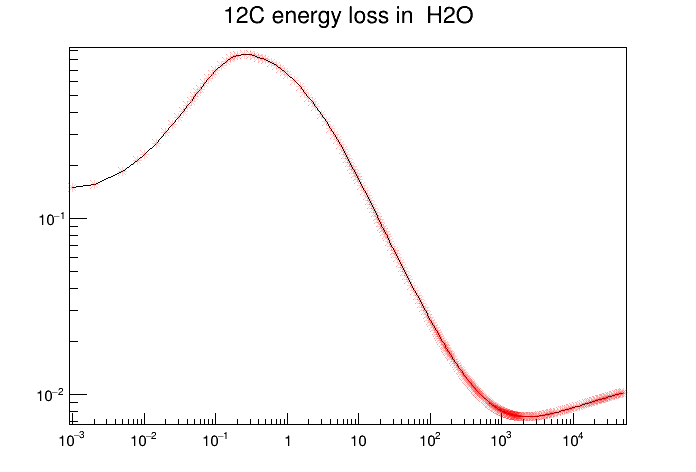

In [7]:
TCanvas *c1 = new TCanvas();
gCdEdx->SetTitle("12C energy loss in  H2O");
gCdEdx->SetLineColor(1);
gCdEdx->SetMarkerColorAlpha(kRed,0.2);
gCdEdx->Draw("AL*");
c1->SetLogy();
c1->SetLogx();
c1->Draw();

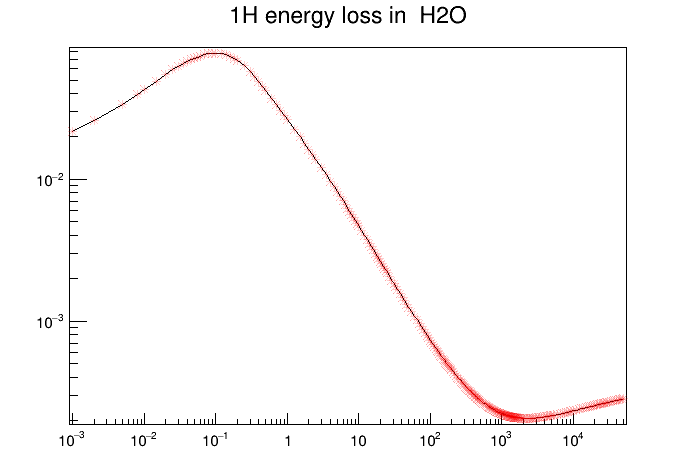

In [8]:
TCanvas *c2 = new TCanvas();
gHdEdx->SetTitle("1H energy loss in  H2O");
gHdEdx->SetLineColor(1);
gHdEdx->SetMarkerColorAlpha(kRed,0.2);
gHdEdx->Draw("AL*");
c2->SetLogy();
c2->SetLogx();
c2->Draw();

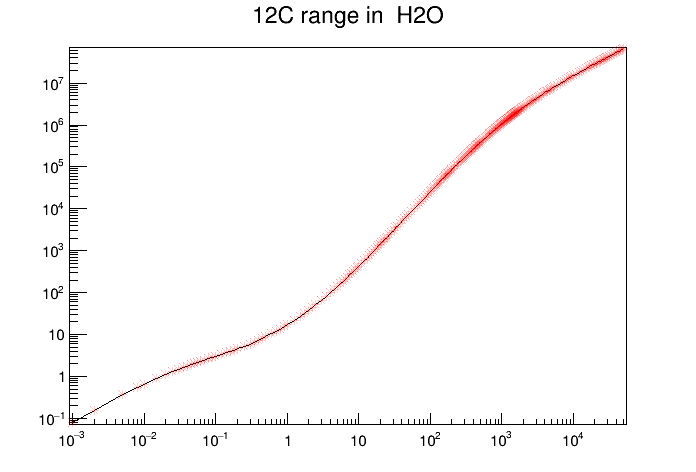

In [9]:
TCanvas *c3 = new TCanvas();
gCER->SetTitle("12C range in  H2O");
gCER->SetLineColor(1);
gCER->SetMarkerColorAlpha(kRed,0.2);
gCER->Draw("AL*");
c3->SetLogy();
c3->SetLogx();
c3->Draw();

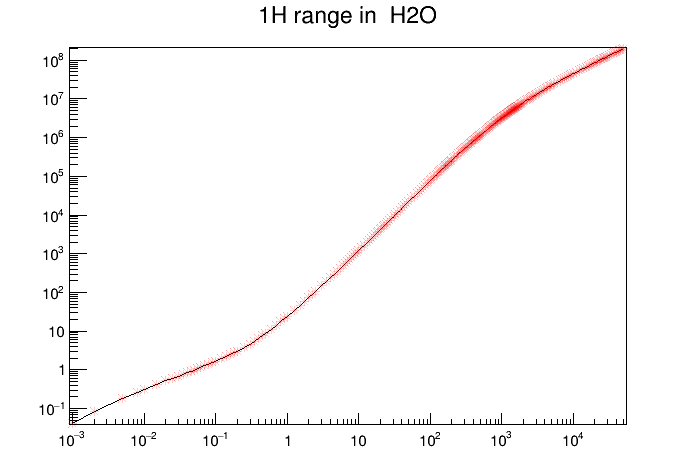

In [10]:
TCanvas *c4 = new TCanvas();
gHER->SetTitle("1H range in  H2O");
gHER->SetLineColor(1);
gHER->SetMarkerColorAlpha(kRed,0.2);
gHER->Draw("AL*");
c4->SetLogy();
c4->SetLogx();
c4->Draw();

使用方法一计算

calculate end
calculate end


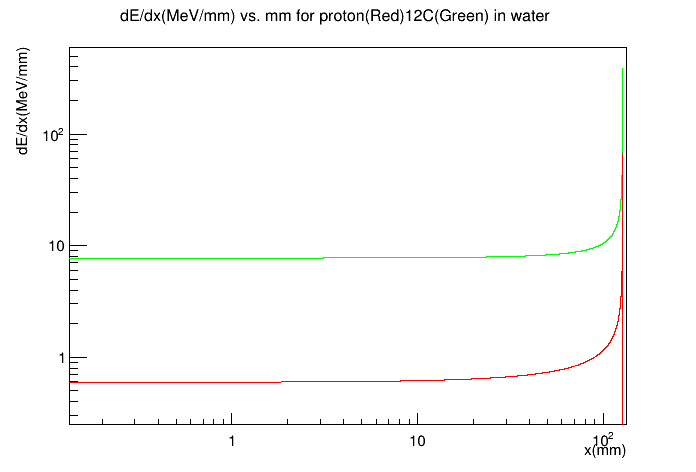

In [11]:
TGraph *gC1 = dEdXx1(12,15562.8,0.01,gCdEdx);
TGraph *gH1 = dEdXx1(1,133.062,0.01,gHdEdx);
merge(gC1,gH1)->Draw();

使用方法二计算

calculate end


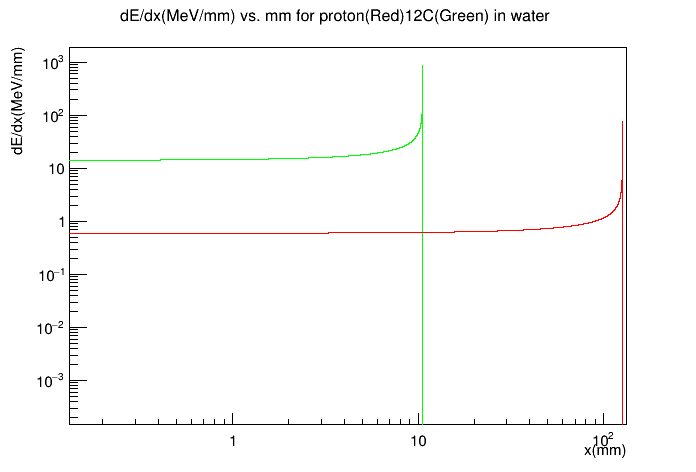

calculate end


In [12]:
/*TGraph *gC2 = dEdXx2(12,15562.8,0.01,gCdEdx);
TGraph *gH2 = dEdXx2(1,133.062,0.01,gHdEdx);
merge(gC2,gH2)->Draw();*/

TGraph *gC2 = dEdXx2(12,0.01,gCER,gCdEdx);
TGraph *gH2 = dEdXx2(1,0.01,gHER,gHdEdx);
merge(gC2,gH2)->Draw();

使用方法三计算

Energy of incident particle is:15562.8MeV.


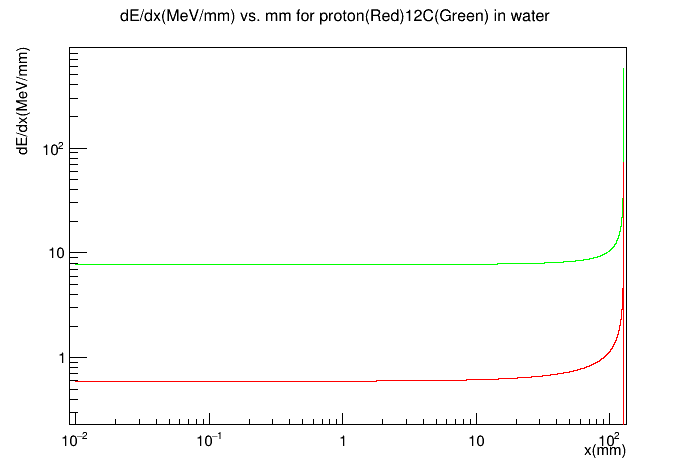

Energy of incident particle is:133.062MeV.


In [13]:
TGraph *gC3 = dEdXx3(12,0.01,gCdEdx);
TGraph *gH3 = dEdXx3(1,0.01,gHdEdx);
merge(gC3,gH3)->Draw();

## 讨论 

（1）比较用不同方法求解的结果，讨论产生差异的原因，且分析其是否合理
不同结果产生差异的原因主要在求解方式的不同，采用不同的计算方法，每一步得到的值不同，而每两步之间的差值与插值算法有关，改变
步长和起始点就会改变区间的位置，不同区间会得到不同的插值，由此会产生差异。

（2）思考选取位移步长与能量步长的标准，怎样的选取是合理的
对于位移步长与能量步长，可以根据采样定理来选取步长，只要采样频率大于其最大频率的两倍，就可以用数学计算出较准确的数据

（3）各步的步长一定要选取相同的值吗，如果选取可变步长，理由与选取的标准是什么？
步长不一定是相同值，取可变步长，可变步长在曲线平缓时可以取间隔较大，在曲线变化大的时候间隔较小，要求步长可以还原真实的值